In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.model_selection import train_test_split

In [8]:
#  Download data from google disk

PROFMERS_DIR = '../dataset/profiler/temperature/'
STATION_PATH = '../dataset/Останкино 0 2020 год.xlsx'

files_profmers = [PROFMERS_DIR + obj for obj in os.listdir(PROFMERS_DIR) if os.path.isfile(PROFMERS_DIR + obj)]

#  profilemers
df_profmers = []
for file_path in files_profmers:
    #print('current file path = {}'.format(file_path))
    df = pd.read_csv(file_path, sep="\t", skiprows=19, decimal=',')
    df['datetime'] = pd.to_datetime(df['data time'], format='%d/%m/%Y %H:%M:%S')#pd.to_datetime(df['data time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df_profmers.append(df)
df_pr = pd.concat(df_profmers)
df_pr.sort_index(inplace=True) 

#  station
df_station = pd.read_excel(STATION_PATH)



In [9]:
#  Make timestap index 
df_station['datetime'] = pd.to_datetime(df_station['Дата и время'], format='%d/%m/%Y %H:%M:%S')
df_station.set_index('datetime', inplace=True)

df_pr.reindex(df_station.index)

# Merge station data and profilemers
X = df_station.join(df_pr)

In [10]:
# Drop features if all values are missing
df_t = X.isnull().all()
drop_features = df_t[df_t == True].index.to_list()

# Drop features if there are only unique value
for feature in X.columns:
    if len(X[feature].unique()) < 2:
        drop_features.append(feature)

# Drop depricated time data
depricated_datetime = ['Дата и время', 'data time']
for feature in depricated_datetime:
    if feature in X.columns:
        drop_features.append(feature)

print('Features to drop:', drop_features)
X = X.drop(columns=drop_features)
X.dropna(inplace=True)

drop_features = []
# Drop features if there are only unique value
for feature in X.columns:
    if len(X[feature].unique()) < 2:
        drop_features.append(feature)


print('Features to drop:', drop_features)
X = X.drop(columns=drop_features)
X.dropna(inplace=True)


Features to drop: ['Unnamed: 6', 'Unnamed: 6', 'Дата и время', 'data time']
Features to drop: ['Quality']


In [12]:
def transfer_series_to_samples(df, target_features, n_input=1, n_output=1):
    variables_names = df.columns.to_list()
    number_of_columns = df.shape[1]

    col_values, col_names = [], []
    y_values, y_col_names = [], []
    for i in range(n_input, 0, -1):
        col_values.append(df.shift(i))
        col_names += [('{col_name} (t-{step})'.format(col_name=col_name, step=i)) for col_name in variables_names]
    for i in range(0, n_output, 1):
        y_values.append(df[target_features].shift(-i))
        y_col_names += [('{col_name} (t+{step})'.format(col_name=col_name, step=i)) for col_name in variables_names if col_name in target_features]

    X_samples = pd.concat(col_values, axis=1)
    X_samples.columns = col_names
    #X_samples.dropna(inplace=True)

    y_samples = pd.concat(y_values, axis=1)
    y_samples.columns = y_col_names
    #y_samples.dropna(inplace=True)

    return X_samples, y_samples

TARGET_PARAMS = ['CO', 'NO2', 'NO', 'PM10', 'PM2.5']
n_steps_in=504
n_steps_out=72

# Make samples for supervised learning from initial dataframe 
# 1 measurment as input, 1 hour as ouptut
X_samples, y_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=504, n_output=72)

nan_rows = X_samples.isnull().any(axis=1) | y_samples.isnull().any(axis=1)
X_samples, y_samples = X_samples.drop(X_samples[nan_rows].index), y_samples.drop(y_samples[nan_rows].index)

# normalize features
#columns_names = X_samples.columns.to_list()
scaler = MinMaxScaler(feature_range=(0, 1))
X_samples = scaler.fit_transform(X_samples)

# normalize features
columns_names_y = y_samples.columns.to_list()
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_samples = scaler_y.fit_transform(y_samples)

X_samples = X_samples.reshape(X_samples.shape[0], n_steps_in, 25)
y_samples = y_samples.reshape(y_samples.shape[0], n_steps_out, 5)
# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])

X_train, X_test, y_train, y_test = train_test_split(X_samples, y_samples, test_size=0.25)

X_samples.shape

In [30]:
X_samples 

array([[[0.03846154, 0.28683036, 0.00319489, ..., 0.83428981,
         0.84357748, 0.79154519],
        [0.03846154, 0.296875  , 0.00638978, ..., 0.83680057,
         0.84799411, 0.78542274],
        [0.03846154, 0.3046875 , 0.00638978, ..., 0.84110473,
         0.85314685, 0.7851312 ],
        ...,
        [0.        , 0.46763393, 0.0929368 , ..., 0.81433346,
         0.82430399, 0.6664561 ],
        [0.        , 0.44754464, 0.05947955, ..., 0.81878945,
         0.82806622, 0.66171826],
        [0.        , 0.43303571, 0.03345725, ..., 0.81804679,
         0.82881866, 0.64939987]],

       [[0.03846154, 0.296875  , 0.00638978, ..., 0.83680057,
         0.84799411, 0.78542274],
        [0.03846154, 0.3046875 , 0.00638978, ..., 0.84110473,
         0.85314685, 0.7851312 ],
        [0.03846154, 0.3125    , 0.00638978, ..., 0.83177905,
         0.84284137, 0.78017493],
        ...,
        [0.        , 0.44754464, 0.05947955, ..., 0.81878945,
         0.82806622, 0.66171826],
        [0. 

In [31]:
n_steps_in=504
n_steps_out=72
# X_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=n_steps_in, n_output=n_steps_out)

# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])

# choose a number of time steps
#n_steps_in, n_steps_out = 3, 2
# covert into input/output
#X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]
input_features = 25
target_features = 5
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, input_features )))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(target_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/5
32/32 [==============================] - 42s 1s/step - loss: 0.0230 - val_loss: 0.0133
Epoch 2/5
32/32 [==============================] - 39s 1s/step - loss: 0.0127 - val_loss: 0.0118
Epoch 3/5
32/32 [==============================] - 39s 1s/step - loss: 0.0117 - val_loss: 0.0111
Epoch 4/5
32/32 [==============================] - 39s 1s/step - loss: 0.0110 - val_loss: 0.0104
Epoch 5/5
32/32 [==============================] - 39s 1s/step - loss: 0.0103 - val_loss: 0.0099


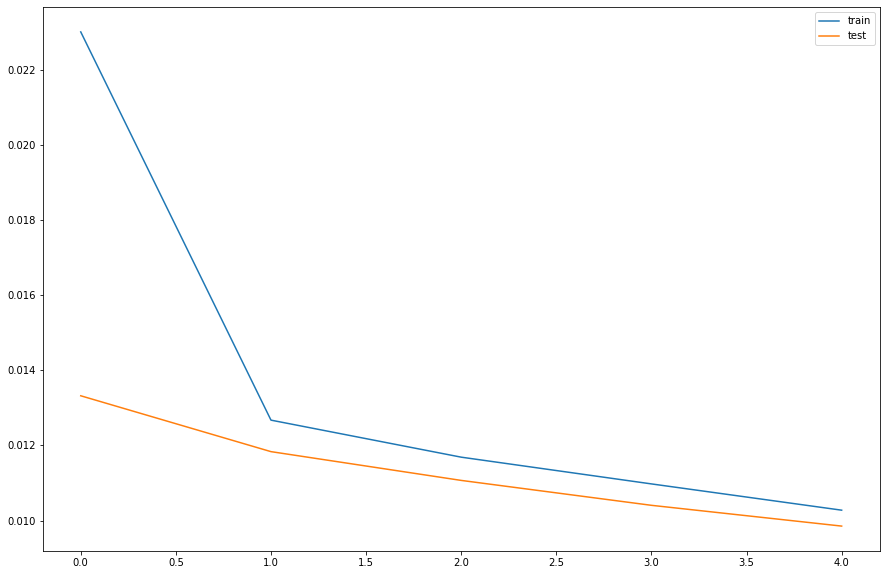

In [33]:
# Train/Test loss chart
# MSE
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.ylim(0, 0.1)
plt.legend()
plt.show()

In [ ]:
a

In [15]:
model.save(filepath='/content/drive/MyDrive/Colab Notebooks/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/assets


In [18]:
import tensorflow as tf

In [21]:
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/', custom_objects=None, compile=True, options=None
)

In [24]:
model.history